In [1]:
%pylab inline
from sshtunnel import SSHTunnelForwarder
import pymongo
import os
import stat
import json
import datetime
import paramiko
import pandas
import seaborn as sns

pkey=os.path.join(os.environ['HOME'],'.ssh/id_rsa')
key=paramiko.RSAKey.from_private_key_file(pkey)

MONGO_HOST = "129.94.162.112"
MONGO_USER = "goios"
MONGO_DB = "test2"
MONGO_COLLECTION = "ls-remote"
local_port = 26017

# define ssh tunnel
with SSHTunnelForwarder(
    MONGO_HOST,
    ssh_username=MONGO_USER,
    ssh_pkey=key,
    remote_bind_address=('localhost', 27017),
    local_bind_address=('localhost',local_port)
) as server:
    connection = pymongo.MongoClient('localhost', local_port)
    # close ssh tunnel
    connection.close()
    server.stop()

Populating the interactive namespace from numpy and matplotlib


In [125]:
MONGO_DB = "modal-2duct-simulations"
#MONGO_DB = "test2"
MONGO_COLLECTION = "random-runs-1"
MONGO_COLLECTION = "random-runs-var-gamma"
MONGO_COLLECTION = "modal-vt-bore-jumps-2"
MONGO_COLLECTION = "modal-vt-bore-many-pars"
with SSHTunnelForwarder(    
    MONGO_HOST,
    ssh_username=MONGO_USER,
    ssh_pkey="~/.ssh/id_rsa",
    remote_bind_address=('localhost', 27017),
    local_bind_address=('localhost',local_port)
) as server:
    with pymongo.MongoClient('localhost', local_port) as connection:
        db = connection[MONGO_DB]
        collection = db[MONGO_COLLECTION]
        print (db)
        print(json.dumps(connection.list_database_names(),indent=2))
        print(json.dumps(db.list_collection_names(), indent=2))    


Database(MongoClient(host=['localhost:26017'], document_class=dict, tz_aware=False, connect=True), 'modal-2duct-simulations')


2020-10-30 17:33:08,898| ERROR   | Could not establish connection from ('127.0.0.1', 26017) to remote side of the tunnel
ERROR:sshtunnel.SSHTunnelForwarder:Could not establish connection from ('127.0.0.1', 26017) to remote side of the tunnel


[
  "admin",
  "config",
  "local",
  "modal-2duct-simulations",
  "test1",
  "test2"
]
[
  "random-runs-var-gamma",
  "random-runs-1",
  "random-runs-var-gamma-pert-time",
  "modal-vt-bore-many-pars",
  "modal-vt-bore-var-gamma-nlstiff-bad-analysis",
  "modal-tests",
  "modal-vt-bore-jumps-2",
  "modal-vt-bore-jumps",
  "modal-vt-bore-var-gamma-nlstiff"
]


In [188]:
with SSHTunnelForwarder(    
    MONGO_HOST,
    ssh_username=MONGO_USER,
    ssh_pkey="~/.ssh/id_rsa",
    remote_bind_address=('localhost', 27017),
    local_bind_address=('localhost',local_port)
) as server:
    with pymongo.MongoClient('localhost', local_port) as connection:
        db = connection[MONGO_DB]
        collection = db[MONGO_COLLECTION]
        print(collection.count())
        print(json.dumps(db.command("dbstats"),indent=2))
#         for d in collection.find():
#             err = "Ok"
#             try:
#                 d['simulation']['error']
#                 err='Error in simulation'
#             except KeyError:
#                 pass
#             try:
#                 d['analysis']['error']
#                 err='Error in analysis'
#             except KeyError:
#                 pass
                
#             print(d['_id'],d['simulation']['start'],d['simulation']['end'],err)
        ll = list(collection.find({'analysis.b1_abs_fin': {'$exists':True}}))
        #ll = list(collection.find({'simulation.params.gamma.sustain_val': {'$gt':.5, '$lt':.6}}))
        #ll = list(collection.aggregate([ {'$match':{'simulation.params.gamma.sustain_val': {'$gt':.6, '$lt':.7}}}, { "$sample": { "size": 1000 } } ]))
    print(len(ll))

  print(collection.count())



3365
{
  "db": "modal-2duct-simulations",
  "collections": 9,
  "views": 0,
  "objects": 219050,
  "avgObjSize": 4362.437571330746,
  "dataSize": 955591950.0,
  "storageSize": 580222976.0,
  "numExtents": 0,
  "indexes": 9,
  "indexSize": 4218880.0,
  "fsUsedSize": 27108777984.0,
  "fsTotalSize": 44780494848.0,
  "ok": 1.0
}
2854


In [189]:
import six

def list_dict_items(obj):
    try:
        for k, v in obj.items():
            yield k, v
    except AttributeError:
        if not isinstance(obj, six.string_types):
            for k, v in enumerate(obj):
                yield k, v

def json_flatten(js,root=""):
    try:
        for k,v in list_dict_items(js):
            yield from json_flatten(v,root=root+"/"+str(k))
    except TypeError:
        yield root[1:], js

def json_array_flatten(js):
    for ii, el in enumerate(js):
        yield {k:v for k,v in json_flatten(el)}
    

In [190]:
{k:v for k,v in json_flatten({'a':1,'b':[0,2,{'a':-1,"b":"hello"}]})}

{'a': 1, 'b/0': 0, 'b/1': 2, 'b/2/a': -1}

In [191]:
dfo=pandas.DataFrame(json_array_flatten(ll))
df=dfo

In [192]:
df['gets larger than perturbation'] = df['analysis/b1_abs_fin'] > df['analysis/b1_abs_pert']

In [193]:
df['finishes close to max'] = df['analysis/b1_abs_fin'] > df['analysis/b1_abs_max']/2

In [194]:
df['trans dur']=df['analysis/t_trans_end']-df['analysis/t_trans_start']

In [195]:
df['starts after pert'] = df['analysis/t_trans_start'] - df['analysis/pert_time'] >-0.002
df['starts after pert'].value_counts()

False    2670
True      184
Name: starts after pert, dtype: int64

In [196]:
df.pivot_table(index=['finishes close to max','gets larger than perturbation'],
               columns='starts after pert', values='analysis/f0', aggfunc='count')

starts after pert                                     False  True 
finishes close to max gets larger than perturbation               
False                 False                            34.0    1.0
                      True                              4.0    NaN
True                  False                          1475.0    NaN
                      True                           1157.0  183.0

In [197]:
from scipy.optimize import fmin

from functools import partial

def resonance(x,f=100,q=10,a=1):
    omegar=2*pi*f
    s = 1j*x*2*pi
    #fs = (a*omegar*q)**0*s**0/(s**2+s*omegar/q+omegar**2)
    fs = omegar*s/(s**2+s*omegar/q+omegar**2)
    return(np.abs(fs))

def impedance(x, fvec, qvec, avec):
    ret = 0*x
    for f, q, a in zip(fvec,qvec,avec):
        ret += resonance(x, f, q, a)
    return ret

fsrch = lambda x: -impedance(x, fvec, qvec, avec)

dbps_to_alpha_fact = log(10)/20

def impedance_info(row):
    zbore = partial(resonance,f=row['simulation/params/bore/frequencies/0'],
                              q=row['simulation/params/bore/qs/0'],
                              a=row['simulation/params/bore/amplitudes/0'])
    zvt = partial(resonance,f=row['simulation/params/vocal/frequencies/0'],
                              q=row['simulation/params/vocal/qs/0'],
                              a=row['simulation/params/vocal/amplitudes/0'])
    ztotal = lambda x: zbore(x)+zvt(x)
    zrat = lambda x: zbore(x)/zvt(x)
    zbore_max_f = fmin(lambda x: -zbore(x),row['simulation/params/bore/frequencies/0'],disp=False)[0]
    zbore_max = zbore(row['analysis/f0'])
    zrat_f0 = zrat(row['analysis/f0'])
    zrat_f_sus = zbore(row['analysis/fb1_abs_sus'])/zvt(row['analysis/fvt1_abs_sus'])
    zrat_f_trans = zbore(row['analysis/fb1_abs_trans'])/zvt(row['analysis/fvt1_abs_trans'])
    srat_f_trans = (zbore(row['analysis/fb1_abs_trans']-1j*row['analysis/b1_rate']*dbps_to_alpha_fact)/
                    zvt(row['analysis/fvt1_abs_trans']-1j*row['analysis/vt1_rate']*dbps_to_alpha_fact))

    return pandas.Series({"zb_max_f":zbore_max_f,"zb_max_val":zbore_max,"zrat_f0":zrat_f0,
                          "zrat_f_sus": zrat_f_sus, "zrat_f_trans": zrat_f_trans,
                          "srat_f_trans": srat_f_trans})



In [198]:
row = df.sample().iloc[0]
row[['analysis/f0','analysis/fb1_abs_trans','analysis/fvt1_abs_trans','analysis/b1_rate','analysis/vt1_rate']]


analysis/f0                696.567
analysis/fb1_abs_trans     656.871
analysis/fvt1_abs_trans    610.884
analysis/b1_rate           4608.97
analysis/vt1_rate          4355.73
Name: 2241, dtype: object

In [199]:
impedance_info(row)

zb_max_f        748.446069
zb_max_val        6.674185
zrat_f0          10.969568
zrat_f_sus       10.969462
zrat_f_trans      4.969972
srat_f_trans      1.829485
dtype: float64

In [200]:
dfc=df.apply(impedance_info,axis=1)

In [201]:
df=pandas.concat((dfo,dfc),axis=1)

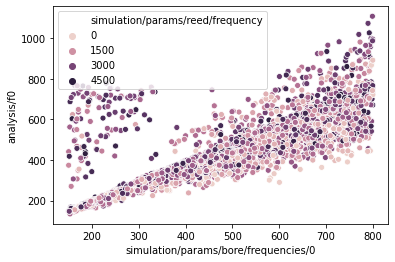

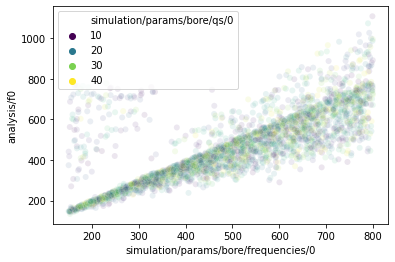

In [202]:
import seaborn as sns
sns.scatterplot(data=df,x='simulation/params/bore/frequencies/0',y='analysis/f0',hue='simulation/params/reed/frequency')
figure()
sns.scatterplot(data=df,x='simulation/params/bore/frequencies/0',y='analysis/f0',hue='simulation/params/bore/qs/0',alpha=.1,palette='viridis')

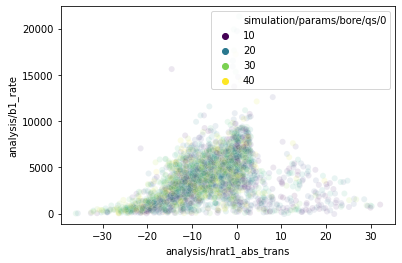

In [205]:
figure()
sns.scatterplot(data=df,x='analysis/hrat1_abs_trans',
                y='analysis/b1_rate',
                hue='simulation/params/bore/qs/0',
                alpha=.1,palette='viridis')

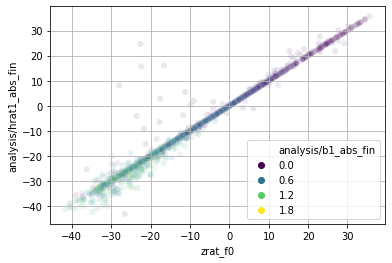

In [206]:
figure()
sns.scatterplot(data=df,x=-20*np.log10(df['zrat_f0']),y='analysis/hrat1_abs_fin',
                hue='analysis/b1_abs_fin',alpha=.1,palette='viridis')
grid()

In [212]:
# select notes triggered by the perturbation
df1 = df[df['starts after pert'] & (df['trans dur']>0.01)]
len(df1)

167

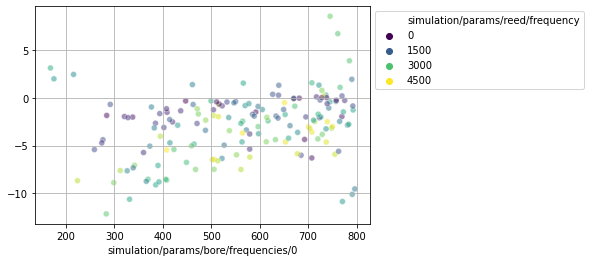

In [213]:
figure()
sns.scatterplot(data=df1,y=-20*np.log10(df['zrat_f_trans'])-df['analysis/hrat1_abs_trans'],
                x='simulation/params/bore/frequencies/0',
                hue='simulation/params/reed/frequency',alpha=.5,palette='viridis')
legend(bbox_to_anchor=(1,1))
grid()

In [214]:
dbps_to_alpha_fact

0.11512925464970229

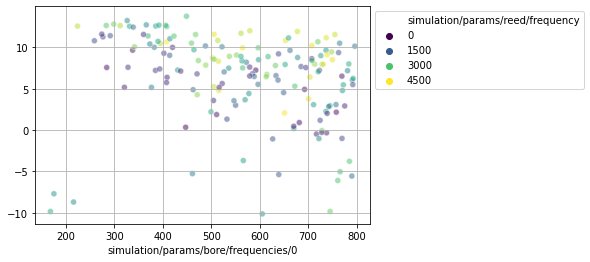

In [215]:
figure()
sns.scatterplot(data=df1,y=-20*np.log10(df['srat_f_trans'])-df['analysis/hrat1_abs_trans'],
                x='simulation/params/bore/frequencies/0',
                hue='simulation/params/reed/frequency',alpha=.5,palette='viridis')
legend(bbox_to_anchor=(1,1))
grid()

In [216]:
df1.columns.to_list()

['_id',
 'simulation/start',
 'simulation/params/tmax',
 'simulation/params/gamma/sustain_val',
 'simulation/params/gamma/time_const',
 'simulation/params/gamma/exp_limit_multiplier',
 'simulation/params/zeta',
 'simulation/params/reed/frequency',
 'simulation/params/reed/q',
 'simulation/params/reed/amplitude',
 'simulation/params/bore/frequencies/0',
 'simulation/params/bore/qs/0',
 'simulation/params/bore/amplitudes/0',
 'simulation/params/vocal/frequencies/0',
 'simulation/params/vocal/qs/0',
 'simulation/params/vocal/amplitudes/0',
 'simulation/params/nlfunc/nl_start',
 'simulation/params/nlfunc/nl_ev',
 'simulation/params/perturbation/multiplier',
 'simulation/params/perturbation/duration',
 'simulation/params/simulation/sample rate',
 'simulation/end',
 'analysis/pert_time',
 'analysis/initial amplitude',
 'analysis/final amplitude',
 'analysis/f0',
 'analysis/f_0',
 'analysis/b0_t_min',
 'analysis/b0_t_max',
 'analysis/b0_abs_min',
 'analysis/b0_abs_max',
 'analysis/b0_abs_fin'

In [218]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression

dep = -20*np.log10(df1['zrat_f_trans'])-df1['analysis/hrat1_abs_trans']
idx = ~dep.isna()
df2 = df1.loc[idx,df1.columns.str.contains('params')]
print(len(df2))
pandas.Series(mutual_info_regression(df2[idx],dep[idx]),index=df2.columns)

167


simulation/params/tmax                          0.000000
simulation/params/gamma/sustain_val             0.045334
simulation/params/gamma/time_const              0.000000
simulation/params/gamma/exp_limit_multiplier    0.000000
simulation/params/zeta                          0.000000
simulation/params/reed/frequency                0.125589
simulation/params/reed/q                        0.000000
simulation/params/reed/amplitude                0.000000
simulation/params/bore/frequencies/0            0.110488
simulation/params/bore/qs/0                     0.019473
simulation/params/bore/amplitudes/0             0.019473
simulation/params/vocal/frequencies/0           0.122867
simulation/params/vocal/qs/0                    0.018225
simulation/params/vocal/amplitudes/0            0.018225
simulation/params/nlfunc/nl_start               0.000000
simulation/params/nlfunc/nl_ev                  0.000000
simulation/params/perturbation/multiplier       0.000000
simulation/params/perturbation/

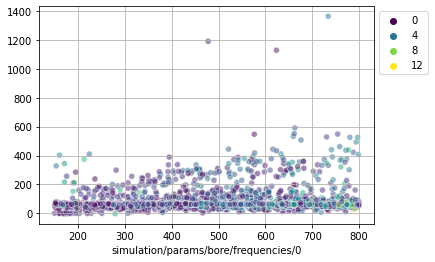

In [219]:
figure()
df2 = df#df1.sample(500)
sns.scatterplot(data=df2,y=df2['trans dur']*df2['analysis/b1_rate'],x='simulation/params/bore/frequencies/0',
                hue=df2['simulation/params/perturbation/duration']*df2['analysis/f0'],alpha=.5,palette='viridis')
legend(bbox_to_anchor=(1,1))
#xscale('log')
#yscale('log')
#ylim([100,10000])
grid()

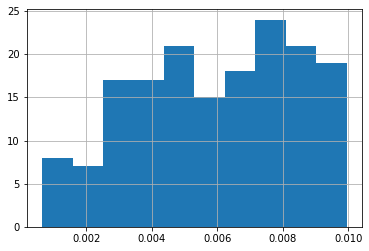

In [220]:
df1['simulation/params/perturbation/duration'].hist()

In [221]:
dep = df1['trans dur']*df1['analysis/b1_rate']
idx = ~dep.isna()
df2 = df1.loc[idx,df1.columns.str.contains('params')]
pandas.Series(mutual_info_regression(df2[idx],dep[idx]),index=df2.columns)

simulation/params/tmax                          0.000000
simulation/params/gamma/sustain_val             0.187356
simulation/params/gamma/time_const              0.000000
simulation/params/gamma/exp_limit_multiplier    0.000000
simulation/params/zeta                          0.163049
simulation/params/reed/frequency                0.019180
simulation/params/reed/q                        0.000000
simulation/params/reed/amplitude                0.000000
simulation/params/bore/frequencies/0            0.137739
simulation/params/bore/qs/0                     0.000000
simulation/params/bore/amplitudes/0             0.000000
simulation/params/vocal/frequencies/0           0.193853
simulation/params/vocal/qs/0                    0.000000
simulation/params/vocal/amplitudes/0            0.000000
simulation/params/nlfunc/nl_start               0.000000
simulation/params/nlfunc/nl_ev                  0.000000
simulation/params/perturbation/multiplier       0.000000
simulation/params/perturbation/

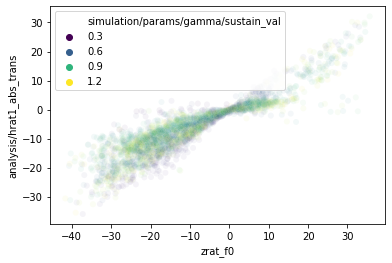

In [222]:
figure()
sns.scatterplot(data=df,x=-20*np.log10(df['zrat_f0']),y='analysis/hrat1_abs_trans',
                hue='simulation/params/gamma/sustain_val',alpha=.05,palette='viridis')

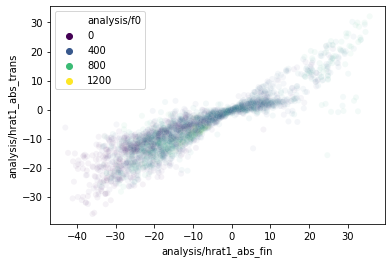

In [223]:
figure()
sns.scatterplot(data=df,x='analysis/hrat1_abs_fin',y='analysis/hrat1_abs_trans',hue='analysis/f0',alpha=.05,palette='viridis')

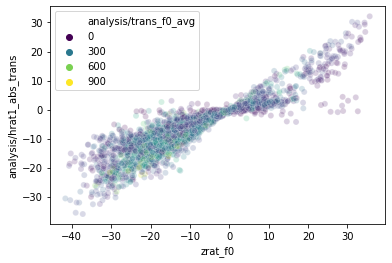

In [224]:
figure()
sns.scatterplot(data=df,x=-20*np.log10(df['zrat_f0']),y='analysis/hrat1_abs_trans',hue='analysis/trans_f0_avg',alpha=.2,palette="viridis")

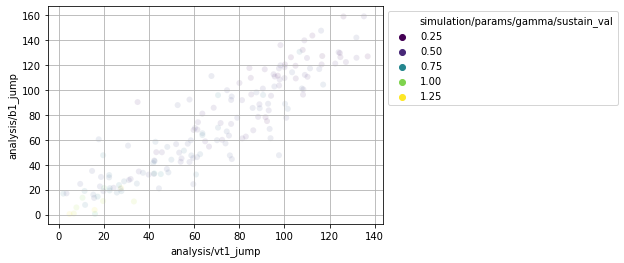

In [225]:
figure()
sns.scatterplot(data=df1,y='analysis/b1_jump',x='analysis/vt1_jump',
                hue='simulation/params/gamma/sustain_val',alpha=.1,palette='viridis')
legend(bbox_to_anchor=(1,1))
grid()


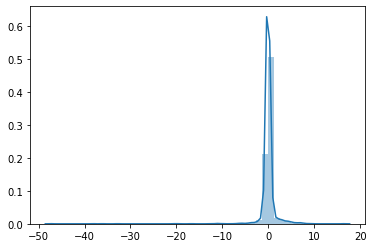

In [226]:
figure()
sns.distplot(-20*np.log10(df['zrat_f0'])-df['analysis/hrat1_abs_fin'])

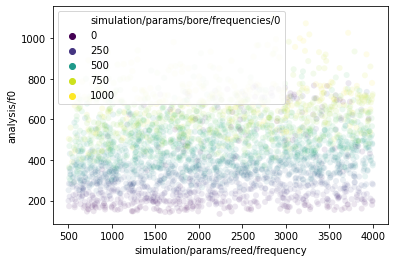

In [227]:
figure()
sns.scatterplot(data=df,x='simulation/params/reed/frequency',y='analysis/f0',hue='simulation/params/bore/frequencies/0',palette='viridis',alpha=.1)

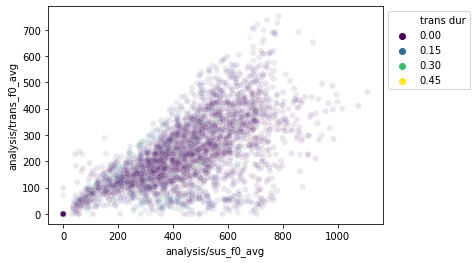

In [228]:
figure()
sns.scatterplot(data=df,x='analysis/sus_f0_avg',y='analysis/trans_f0_avg',hue='trans dur',alpha=0.1,palette='viridis',vmax=0.1)
legend(bbox_to_anchor=(1,1),loc='upper left')

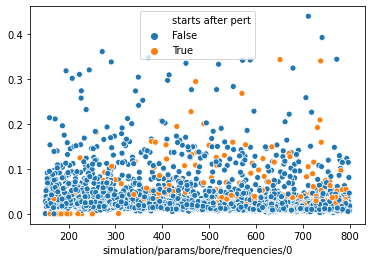

In [229]:
figure()
sns.scatterplot(data=df,x='simulation/params/bore/frequencies/0',y=df['analysis/t_trans_end']-df['analysis/t_trans_start'],hue='starts after pert')

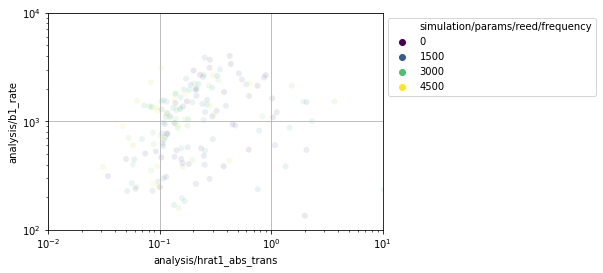

In [230]:
figure()
df2 = df1[df1['analysis/f0']<900]
sns.scatterplot(data=df2,x=10**(df1['analysis/hrat1_abs_trans']/20),
                y='analysis/b1_rate',
                hue='simulation/params/reed/frequency',
                alpha=.1,palette='viridis')
xscale('log')
xlim(1e-2,1e1)
ylim(1e2,1e4)
yscale('log')
legend(loc='upper left',bbox_to_anchor=(1,1))
grid()

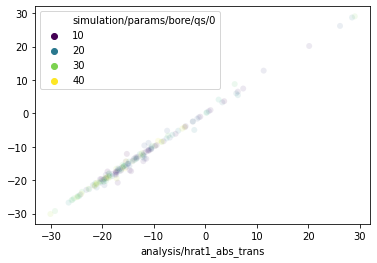

In [231]:
figure()
sns.scatterplot(data=df1,x='analysis/hrat1_abs_trans',
                y=20*np.log10(df1['analysis/vt1_abs_trans']/df1['analysis/b1_abs_trans']),
                hue='simulation/params/bore/qs/0',
                alpha=.1,palette='viridis')

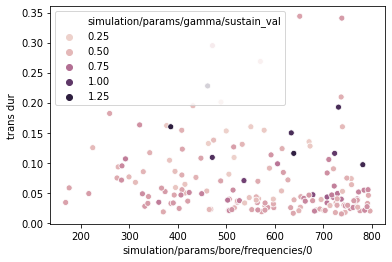

In [232]:
import seaborn as sns
figure()
sns.scatterplot(data=df1,x='simulation/params/bore/frequencies/0',y='trans dur',hue='simulation/params/gamma/sustain_val')

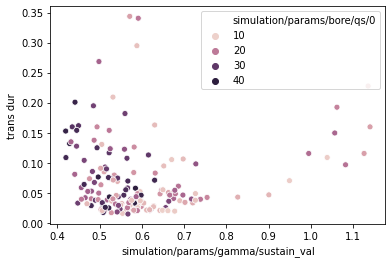

In [233]:
figure()
sns.scatterplot(data=df1,hue='simulation/params/bore/qs/0',y='trans dur',x='simulation/params/gamma/sustain_val')

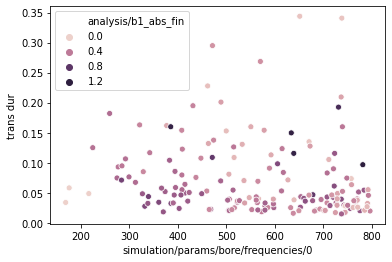

In [234]:
figure()
sns.scatterplot(data=df1,x='simulation/params/bore/frequencies/0',y='trans dur',hue='analysis/b1_abs_fin')

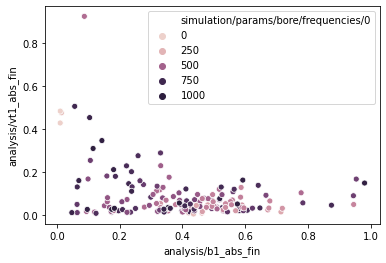

In [235]:
figure()
sns.scatterplot(data=df1,y='analysis/vt1_abs_fin',x='analysis/b1_abs_fin',hue='simulation/params/bore/frequencies/0')

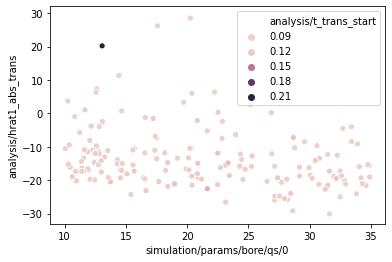

In [236]:
figure()
sns.scatterplot(data=df1,hue='analysis/t_trans_start',y='analysis/hrat1_abs_trans',x='simulation/params/bore/qs/0')

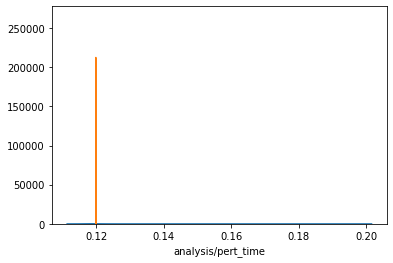

In [237]:
figure()
sns.distplot(df1['analysis/t_trans_start'],norm_hist=False)
sns.distplot(df1['analysis/pert_time'],norm_hist=False)

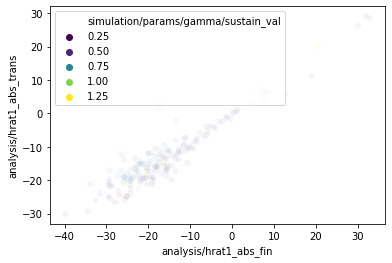

In [238]:
figure()
sns.scatterplot(data=df1,x='analysis/hrat1_abs_fin',y='analysis/hrat1_abs_trans',hue='simulation/params/gamma/sustain_val',alpha=.05,palette='viridis')

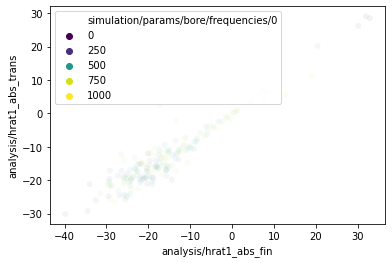

In [239]:
figure()
sns.scatterplot(data=df1,x='analysis/hrat1_abs_fin',y='analysis/hrat1_abs_trans',
                hue='simulation/params/bore/frequencies/0',palette='viridis',alpha=0.05)

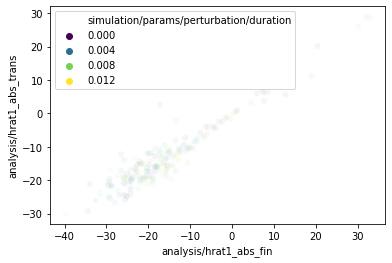

In [240]:
figure()
sns.scatterplot(data=df1,x='analysis/hrat1_abs_fin',y='analysis/hrat1_abs_trans',
                hue='simulation/params/perturbation/duration',palette='viridis',alpha=0.05)

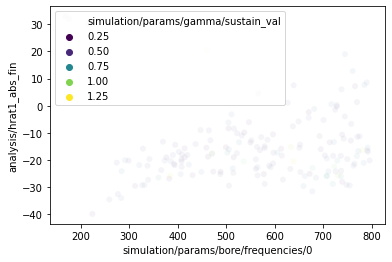

In [241]:
figure()
sns.scatterplot(data=df1,y='analysis/hrat1_abs_fin',hue='simulation/params/gamma/sustain_val',x='simulation/params/bore/frequencies/0',
                palette='viridis',alpha=0.05)

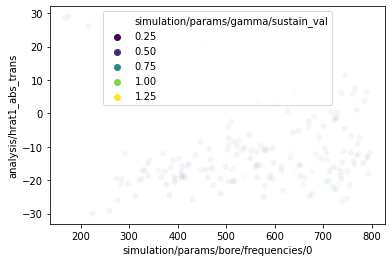

In [242]:
figure()
sns.scatterplot(data=df1,y='analysis/hrat1_abs_trans',hue='simulation/params/gamma/sustain_val',
                x='simulation/params/bore/frequencies/0',
                palette='viridis',alpha=0.05)

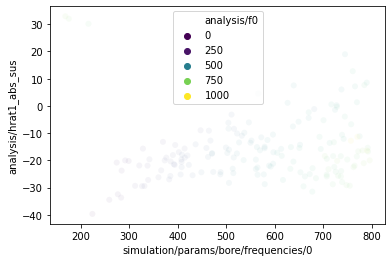

In [243]:
figure()
sns.scatterplot(data=df1,y='analysis/hrat1_abs_sus',hue='analysis/f0',
                x='simulation/params/bore/frequencies/0',
                palette='viridis',alpha=0.05)

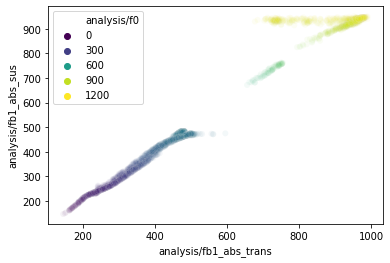

In [47]:
figure()
sns.scatterplot(data=df1,y='analysis/fb1_abs_sus',hue='analysis/f0',
                x='analysis/fb1_abs_trans',
                palette='viridis',alpha=0.05)

In [48]:
{col:len(df[col].unique())for col in df.columns}

{'_id': 7109,
 'simulation/start': 7109,
 'simulation/params/tmax': 1,
 'simulation/params/gamma/sustain_val': 7109,
 'simulation/params/gamma/time_const': 1,
 'simulation/params/gamma/exp_limit_multiplier': 1,
 'simulation/params/zeta': 1,
 'simulation/params/reed/frequency': 7109,
 'simulation/params/reed/q': 7109,
 'simulation/params/reed/amplitude': 7109,
 'simulation/params/bore/frequencies/0': 7109,
 'simulation/params/bore/qs/0': 7109,
 'simulation/params/bore/amplitudes/0': 7109,
 'simulation/params/vocal/frequencies/0': 1,
 'simulation/params/vocal/qs/0': 1,
 'simulation/params/vocal/amplitudes/0': 1,
 'simulation/params/nlfunc/nl_start': 1,
 'simulation/params/nlfunc/nl_ev': 1,
 'simulation/params/perturbation/multiplier': 1,
 'simulation/params/perturbation/duration': 7109,
 'simulation/params/simulation/sample rate': 7109,
 'simulation/end': 7109,
 'analysis/pert_time': 7109,
 'analysis/initial amplitude': 7109,
 'analysis/final amplitude': 7109,
 'analysis/f0': 7087,
 'ana

In [49]:
start = datetime.datetime(2020, 1, 1, 0, 0, 0, 0)
#end = datetime.datetime(2012, 2, 2, 6, 55, 3, 381)

    
with SSHTunnelForwarder(    
    MONGO_HOST,
    ssh_username=MONGO_USER,
    ssh_pkey="~/.ssh/id_rsa",
    remote_bind_address=('localhost', 27017),
    local_bind_address=('localhost',local_port)
) as server:
    with pymongo.MongoClient('localhost', local_port) as connection:
        db = connection[MONGO_DB]
        collection = db[MONGO_COLLECTION]

        #for f in os.listdir('.'):
        #    collection.insert_one({'name':f, 'time':os.stat(f).st_mtime, 'size':os.stat(f).st_size})
        for doc in collection.find({'time.modification':{'$gte': start}}):
            print(json.dumps(doc,default=str,indent=2))


In [50]:
from random_single_mode_vt_bore_reed import ivp_simulate, do_analysis

def simulate_js(js):
    data = ivp_simulate(js)
    analysis = do_analysis(data, impedance=False)
 
    return data,analysis

In [51]:
import os
import numpy as np
from glob import glob
from pypevoc.Heterodyne import HeterodyneHarmonic
from pypevoc.PVAnalysis import PV
import timeseries as ts
import scipy.signal as sig

def db(x):
    return 20*np.log10(x)



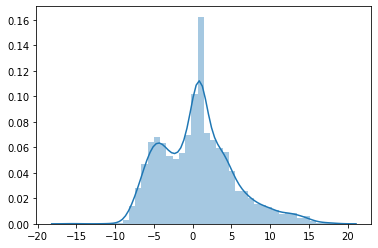

In [52]:
plt.figure()
sns.distplot(df1['analysis/hrat1_abs_trans']-df1['analysis/hrat1_abs_fin'])

In [53]:
import random
from json_object import JSONObject

#row = df[np.abs(-20*np.log10(df['zrat_f0'])-df['analysis/hrat1_abs_fin'])>5].sample().iloc[0]
#row = df[df['analysis/hrat1_abs_fin']<-20].sample().iloc[0]
# row = df1[df1['analysis/hrat1_abs_trans']-df1['analysis/hrat1_abs_fin']<-10].sample().iloc[0]
row = df1.sample().iloc[0]
idx= row.name
print(row['analysis/hrat1_abs_fin'],-20*np.log10(row['zrat_f0']))
data,anal=simulate_js(JSONObject(ll[idx]['simulation']['params']))

14.865522626189655 12.97412728594113
1966.08
1966.08
1966.08
1966.08
1890.4615384615379
1966.08
1966.08
1966.08
1966.08
1890.4615384615379
Error in exponential estimation in vt0


Traceback (most recent call last):
  File "/Users/goios/Devel/vocalsims/projects/clarinet_vocal_tract/modal_simulations/simulation_harmonic_transient_analyser.py", line 237, in do_analysis
    rm=RANSACRegressor().fit(X,y)
  File "/Users/goios/Envs/unsw/lib/python3.8/site-packages/sklearn/linear_model/_ransac.py", line 281, in fit
    raise ValueError("`min_samples` may not be larger than number "
ValueError: `min_samples` may not be larger than number of samples: n_samples = 1.


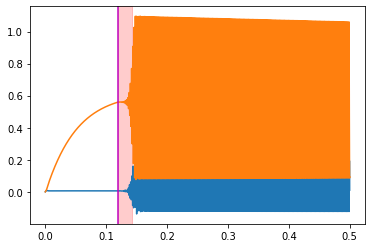

In [54]:
figure()
t = np.arange(len(data['p_b']))/data['js']['simulation']['sample rate']
plot(t,data['p_b'])
plot(t,data['p_vt']+data['p_blow'])
axvline(anal['pert_time'],color='m')
axvspan(anal['t_trans_start'],anal['t_trans_end'],color='r',alpha=.2)

In [55]:
row['analysis/f0']

460.68302479151805

In [56]:
close('all')

In [57]:
t_init=[0.01,0.05]
t_fin=0.1
tsust=0.1

# extract main parameters
res = {}
sr = data['js']['simulation']['sample rate']
pb = data['p_b']
pvt = data['p_vt']
t = np.arange(len(pb))/sr
if data['pert_time']>0:
    res['pert_time']=data['pert_time']
else:
    res['pert_time'] = 0


pbinit = pb[int(t_init[0]*sr):int(t_init[1]*sr)]
res['initial amplitude'] = np.max(pbinit)-np.min(pbinit)
pbfin = pb[-int(t_fin*sr):]
res['final amplitude'] = np.max(pbfin)-np.min(pbfin) 

# fundamental frequency for harmonic analysis
pvpb = PV(pb,sr=sr,progress=False,nfft=1024*16,hop=512*2,pkthresh=1e-10)
pvpb.run_pv()
fts = ts.SampledTimeSeries(pvpb.fundamental_frequency, pvpb.t)

f0 = fts.percentile(50,from_time=fts.t[-1]-0.2)
if f0<20:
    f0 = np.median(fts.v[fts.v>0])
res['f0'] = f0
fw,pbw = sig.welch(pb,nperseg=2**10,nfft=2**12,fs=sr)

mainf = pvpb.f[np.arange(pvpb.f.shape[0]),np.argmin(np.abs(pvpb.f-f0),axis=1)]
mainfts = ts.SampledTimeSeries(mainf, pvpb.t)

# harmonic analysis
try:
    nwind = int(sr/f0*3)
except ValueError:
    nwind = 1024


ha = {}
for lab in ('b', 'vt', 'm'):
    try:
        p = data['p_{}'.format(lab)]
    except KeyError:
        continue

    h = HeterodyneHarmonic(p,sr=sr,tf=[0,max(pvpb.t)],f=[f0,f0],nwind=nwind,nhop=128)
    h_array = [ts.SampledTimeSeries(np.abs(h.camp[:,ii]),h.t,label='h{}{}'.format(lab,ii+1)) for ii in range(h.camp.shape[1])]
    ha[lab] = h_array
    for ii, hts in enumerate(h_array):
        res['{}_t_min'.format(hts.label)]=hts.min_time()
        res['{}_t_max'.format(hts.label)]=hts.max_time()
        res['{}_abs_min'.format(hts.label)]=hts.min()
        res['{}_abs_max'.format(hts.label)]=hts.max()
        res['{}_abs_fin'.format(hts.label)]=hts.v[-1]
        if data['pert_time']>1e-4:
            res['{}_abs_pert'.format(hts.label)]=hts[data['pert_time']]
        else:
            res['{}_abs_pert'.format(hts.label)]=np.nan    

hts_array = ha['b']
vts_array = ha['vt']

# transient detection using one envelope
ats = hts_array[0]

amax = ats.max()

a_trans_end = amax*.7
a_trans_start = amax*.001
try:
    t_trans_end = ats.crossing_times(a_trans_end)[0][0]
except IndexError:
    t_trans_end = ats.v[-1]
try:
    t_trans_start = ats.crossing_times(a_trans_start,to_time=t_trans_end)[0][0]
except IndexError:
    t_trans_start = t_trans_end - ats.dt

atrans, ttrans = ats.apply(db).times_values_in_range(from_time=t_trans_start,to_time=t_trans_end)

# frequency comparison
fsusav = fts.mean(from_time=fts.t[-1]-tsust)
res['t_trans_start']=t_trans_start
res['t_trans_end']=t_trans_end
res['sus_f0_avg']=fts.mean(from_time=fts.t[-1]-tsust)
res['sus_f0_std']=fts.std(from_time=fts.t[-1]-tsust)
res['trans_f0_avg']=fts.mean(from_time=t_trans_start, to_time=t_trans_end)
res['trans_f0_std']=fts.std(from_time=t_trans_start, to_time=t_trans_end)

# harmonic descriptor extraction
for h_array in (hts_array,vts_array):
    for ii, hts in enumerate(h_array):
        res['{}_abs_sus'.format(hts.label)]=hts.percentile(50,from_time=fts.t[-1]-tsust)
        res['{}_abs_sus_var'.format(hts.label)]=np.diff(hts.percentile([75,25],from_time=fts.t[-1]-tsust))[0]
        res['{}_abs_trans'.format(hts.label)]=hts.percentile(50,from_time=t_trans_start, to_time=t_trans_end)
        res['{}_abs_trans_var'.format(hts.label)]=np.diff(hts.percentile([75,25],from_time=t_trans_start, to_time=t_trans_end))[0]

    # growth rate via derivative
    dts = hts.apply(db).diff()
    dts.label = hts.label
    for pct in [25,50,75]:
        res['{}_trans_rate_pct{}'.format(dts.label,pct)]=dts.percentile(pct,from_time=t_trans_start, to_time=t_trans_end)

    res['{}_abs_fin'.format(hts.label)]=hts.v[-1]
    if data['pert_time']>1e-4:
        res['{}_abs_pert'.format(hts.label)]=hts[data['pert_time']]
    else:
        res['{}_abs_pert'.format(hts.label)]=np.nan    

# harmonic ratio descriptors
for ii, hts in enumerate(hts_array):
    vts = vts_array[ii]
    rts = vts.apply(db)-hts.apply(db)
    rts.label = 'hrat{}'.format(ii+1)
    res['{}_abs_sus'.format(rts.label)]=rts.percentile(50,from_time=fts.t[-1]-tsust)
    res['{}_abs_sus_var'.format(rts.label)]=np.diff(rts.percentile([75,25],from_time=fts.t[-1]-tsust))[0]
    res['{}_abs_trans'.format(rts.label)]=rts.percentile(50,from_time=t_trans_start, to_time=t_trans_end)
    res['{}_abs_trans_var'.format(rts.label)]=np.diff(rts.percentile([75,25],from_time=t_trans_start, to_time=t_trans_end))[0]
    res['{}_abs_fin'.format(rts.label)]=rts.v[-1]
    if data['pert_time']>1e-4:
        res['{}_abs_pert'.format(rts.label)]=rts[data['pert_time']]
    else:
        res['{}_abs_pert'.format(rts.label)]=np.nan    



  frat = fx / self.oldfft

  frat = fx / self.oldfft



In [58]:
from pypevoc.Heterodyne import heterodyne

def heterodyne_corr(x,sr,f,maxwind=2**14,nhop=2**10,nper=3,dc_cut=50):
    #c1,_ = heterodyne(x,x,wind=np.hanning(nwind),hop=nhop)
    xx = x.copy()
#     newn = int(len(xx)/sr*dc_cut)
#     x2 = np.concatenate((xx,np.zeros(int((newn+1)*sr/dc_cut))))
#     print(newn,x2.shape)
#     xd = sig.resample(x2,newn)
#     xu = sig.resample(xd,len(x2))[:len(xx)]
#     xx -= xu
    t = np.arange(len(x))/sr
    #npts = len(c1)
    nharm = len(f)
    #camp = np.zeros((npts,nharm),dtype='complex')
    ret = []
    part = np.zeros((len(x),nharm))
    for ii,ff in enumerate(f):
        #nwind = int(min(maxwind,sr/ff*nper))
        if ff==0.:
            nwind=maxwind
        foth = np.delete(f,ii)
        nwind = (sr/np.min(np.abs(foth-ff))*nper)
        print(nwind)
        hetsig = np.exp(1j*2*np.pi*ff*t)
        cc,ih = heterodyne(xx,hetsig,wind=np.hanning(nwind),hop=nhop)
        if ff==0.:
            cc/=2
        th=ih/sr
        ret.append(ts.SampledTimeSeries(cc,th,label='%.2f'%ff))
        hf = np.interp(t,th,cc)
        xp = np.real(np.conjugate(hf)*hetsig)
        xx-=xp
        part[:,ii]=xp
    return ret,xx,part

[   0.          470.07370224  940.14740448 1410.22110673 1899.09775706]
1966.08
1966.08
1966.08
1966.08
1890.4615384615379
1966.08
1966.08
1966.08
1966.08
1890.4615384615379


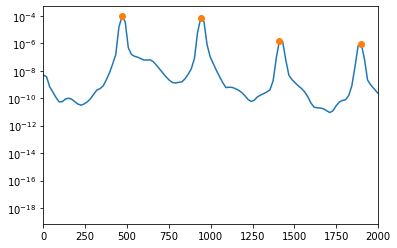

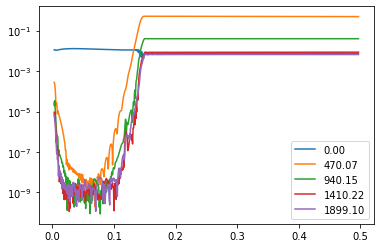

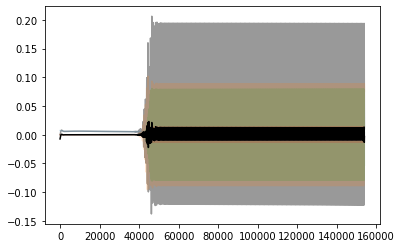

In [59]:
from scipy.signal import welch,find_peaks

fw,w=welch(pb,fs=sr,nperseg=2**14)

fig,ax=subplots(1)
semilogy(fw,w)
xlim(0,2000)

pks,_=find_peaks(10*np.log10(w),prominence=20)
ff=fw[pks]
ff=ff[(ff<2000)&(ff>100)]
nw=int(sr/np.min(ff)*6)
semilogy(fw[pks],w[pks],'o')

ff=np.insert(ff,0,0)

print(ff)

#nw=nwind
nw=2**16
nper=3
hetpb,pbresid,pbpart=heterodyne_corr(pb,sr,ff,maxwind=nw,nhop=128,nper=nper)
hetpv,pvresid,pvpart=heterodyne_corr(pvt,sr,ff,maxwind=nw,nhop=128,nper=nper)
fig,ax=subplots(1)
for tts in hetpv:
    ax.semilogy(tts.t,np.abs(tts.v),label=tts.label)
    
ax.legend()
ax.set_yscale('log')

figure()
plot(pb,color='k',alpha=.4)
plot(pbpart,alpha=.2)
plot(pbresid,color='k')

In [60]:
thr=.05
f0r = f0
for f in ff:
    if f==0:
        continue
    frat = f/f0r
    hno = np.round(frat)
    fdev = np.abs(frat-hno)
    print(f,frat,fdev,fdev<thr,hno)
    #if fdev<thr:
    #    f0r=np.mean([f0r,f/hno])
    

470.0737022416672 0.9945798563322094 0.0054201436677906445 True 1.0
940.1474044833344 1.9891597126644187 0.010840287335581289 True 2.0
1410.2211067250016 2.983739568996628 0.016260431003372045 True 3.0
1899.0977570563357 4.018102619582126 0.01810261958212589 True 4.0


In [61]:
np.diff(fw)[0]

18.80294808966669

In [62]:
f0r

472.6354543064999

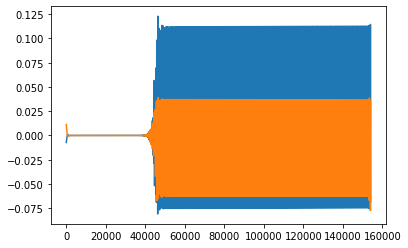

In [63]:
def semilogabsy(x,y,*args,**kwargs):
    return semilogy(x,np.abs(y),*args,**kwargs)
figure()
plot(np.arange(len(pb)),pb-np.sum(pbpart[:,0:2],axis=1))
plot(np.arange(len(pb)),pvt-np.sum(pvpart[:,0:2],axis=1))


472.6354543064999 470.0737022416672


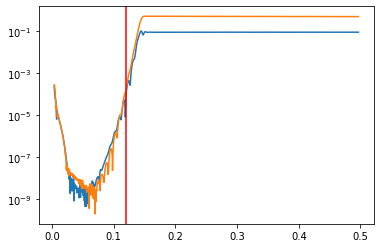

In [64]:
mainidx = np.argmin(np.abs(np.array(ff)-f0))
print( f0,ff[mainidx])
fig,ax=subplots(1)
plot(hetpb[mainidx].t,np.abs(hetpb[mainidx].v))
plot(hetpv[mainidx].t,np.abs(hetpv[mainidx].v))
ax.set_yscale('log')
ax.axvline(data['pert_time'],color='r')

In [65]:
pvt

array([-1.65959182e-05, -3.84693915e-05, -6.13175220e-05, ...,
       -4.63796799e-01, -4.63167685e-01, -4.62505236e-01])

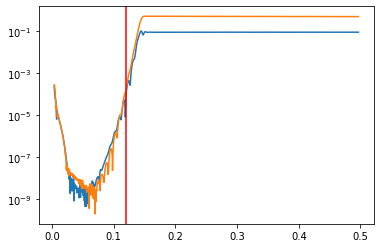

In [66]:
fig,ax=subplots(1)
hb = hetpb[mainidx].apply(np.abs)
hb.plot(ax=ax)
hv = hetpv[mainidx].apply(np.abs)
hv.plot(ax=ax)
ax.axvline(data['pert_time'],color='r')
ax.set_yscale('log')

In [67]:
print(row['analysis/hrat1_abs_trans'],row['analysis/hrat1_abs_fin'],-20*np.log10(row['zrat_f0']))

7.102792194618134 14.865522626189655 12.97412728594113


  zts = mainfts.apply(lambda x: impedance(x,fvec = [row['simulation/params/bore/frequencies/0']],



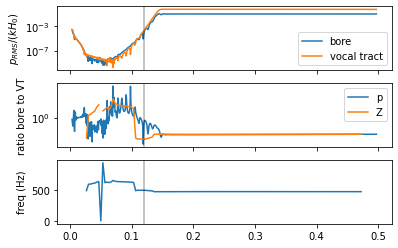

In [68]:

fig,ax = plt.subplots(3,sharex=True)
hb1 = hb.copy()
hb1.label= 'bore'
hb1.plot(ax=ax[0])
hv1 = hv.copy()
hv1.label='vocal tract'
hv1.plot(ax=ax[0])
ax[0].set_yscale('log')
ax[0].set_ylabel('$p_{RMS}/(k H_0)$')
ax[0].legend()
(hb1/hv1).plot(ax=ax[1])
ax[1].set_yscale('log')
ax[1].set_ylabel('ratio bore to VT')
zts = mainfts.apply(lambda x: impedance(x,fvec = [row['simulation/params/bore/frequencies/0']],
         qvec = [row['simulation/params/bore/qs/0']],
         avec=[row['simulation/params/bore/amplitudes/0']])/impedance(x,fvec = [row['simulation/params/vocal/frequencies/0']],
         qvec = [row['simulation/params/vocal/qs/0']],
         avec=[row['simulation/params/vocal/amplitudes/0']]))
zts.plot(ax=ax[1])
ax[1].legend(['p','Z'])

mainfts.plot(ax=ax[2])
ax[2].set_ylabel('freq (Hz)')

for axi in ax:
    axi.axvline(data['pert_time'],color='k',alpha=.3)

  mag = 20*np.log10(self.mag)



(0.0, 2000.0)

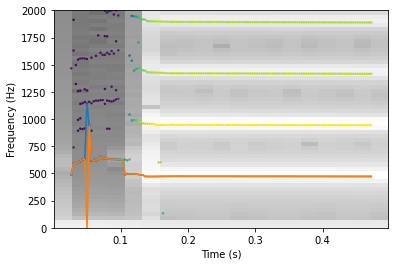

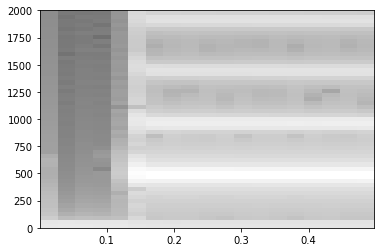

In [69]:
fig,ax = subplots(1)
ax.specgram(data['p_b'],Fs=sr,NFFT=2**13,cmap='gray')
pvpb.plot_time_freq(ax=ax)
ax.plot(pvpb.t,pvpb.fundamental_frequency)
ax.plot(pvpb.t,mainf)
ax.set_ylim(0,2000)
fig,ax = subplots(1)
ax.specgram(data['p_vt'],Fs=sr,NFFT=2**13,cmap='gray')
#pvpb.plot_time_freq(ax=ax)
# ax.plot(pvpb.t,pvpb.fundamental_frequency)
# ax.plot(pvpb.t,mainf)
ax.set_ylim(0,2000)

bore
0.12707923976686797 0.13950510203880387
-414.40188722519724 [2777.14952241]
17.295559568468065
vocal tract
0.12819862318184017 0.14256584058371802
-410.2802547589058 [2801.29353182]
16.862086973361812


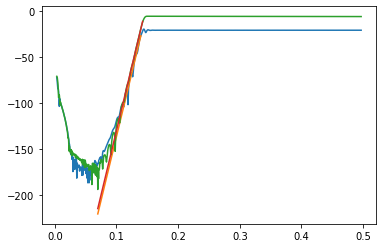

In [70]:
from sklearn.linear_model import RANSACRegressor
fig,ax=subplots(1)
for hh in [hb1,hv1]:
    print(hh.label)
    hbl1=hh.apply(db)
    vals=hbl1.percentile([5,99])
    ted=hbl1.crossing_times(vals[1]-6)[0][0]
    tst=hbl1.crossing_times(vals[1]-46,to_time=ted)[0][-1]
    print(tst,ted)
    x,y=hbl1.times_values_in_range(tst,ted)
    X = np.array([x]).T
    rm=RANSACRegressor().fit(X,y)
    print(rm.estimator_.intercept_,rm.estimator_.coef_)
    fig,ax=hbl1.plot(ax=ax)
    xpred,ytrue = hbl1.times_values_in_range(data['pert_time']-.05,ted)
    Xpred = np.array([xpred]).T
    ypred = rm.predict(Xpred)
    ax.plot(xpred,ypred)
    print (np.max(ypred-ytrue))

In [71]:
y

array([-53.02247536, -51.66397991, -50.31320083, -48.88476537,
       -47.50024236, -46.14382111, -44.80890637, -43.57508907,
       -42.34495403, -41.2147589 , -40.10683829, -39.03429846,
       -38.01619508, -36.95822519, -35.94582664, -34.86892482,
       -33.77357164, -32.65304431, -31.44392668, -30.25373743,
       -28.98201261, -27.7308981 , -26.47449543, -25.19900566,
       -23.98815059, -22.74804271, -21.58362394, -20.42482066,
       -19.28155687, -18.19382446, -17.08961342, -16.06436813,
       -15.03920096, -14.05247114, -13.12085696, -12.20980263])

In [72]:
row.to_dict()

{'_id': ObjectId('5f980ac098b40108a64ef06c'),
 'simulation/start': Timestamp('2020-10-27 22:55:23.380000'),
 'simulation/params/tmax': 0.5,
 'simulation/params/gamma/sustain_val': 0.5711271610022643,
 'simulation/params/gamma/time_const': 0.05,
 'simulation/params/gamma/exp_limit_multiplier': 1.1,
 'simulation/params/zeta': 0.5,
 'simulation/params/reed/frequency': 3080.6750150109906,
 'simulation/params/reed/q': 4.608614015063896,
 'simulation/params/reed/amplitude': 4.608614015063896,
 'simulation/params/bore/frequencies/0': 676.5582281798967,
 'simulation/params/bore/qs/0': 31.036385178569216,
 'simulation/params/bore/amplitudes/0': 31.036385178569216,
 'simulation/params/vocal/frequencies/0': 500,
 'simulation/params/vocal/qs/0': 15,
 'simulation/params/vocal/amplitudes/0': 15,
 'simulation/params/nlfunc/nl_start': 0.75,
 'simulation/params/nlfunc/nl_ev': 1.1,
 'simulation/params/perturbation/multiplier': 1.1,
 'simulation/params/perturbation/duration': 1.3466591787233602,
 'simula

In [73]:
ll[idx]['simulation']['params']

{'description': 'Reed simulation with modal tracts and reed dynamics and non-linear reed force var gamma',
 'version': '20201026',
 'db': 'modal-vt-bore-jumps-2',
 'tmax': 0.5,
 'gamma': {'sustain_val': 0.5711271610022643,
  'time_const': 0.05,
  'exp_limit_multiplier': 1.1},
 'zeta': 0.5,
 'reed': {'frequency': 3080.6750150109906,
  'q': 4.608614015063896,
  'amplitude': 4.608614015063896},
 'bore': {'frequencies': [676.5582281798967],
  'qs': [31.036385178569216],
  'amplitudes': [31.036385178569216]},
 'vocal': {'frequencies': [500], 'qs': [15], 'amplitudes': [15]},
 'nlfunc': {'type': 'parabolic', 'nl_start': 0.75, 'nl_ev': 1.1},
 'perturbation': {'multiplier': 1.1, 'duration': 1.3466591787233602},
 'simulation': {'sample rate': 308067.50150109903}}

In [74]:
df1

,_id,simulation/start,simulation/params/tmax,simulation/params/gamma/sustain_val,simulation/params/gamma/time_const,simulation/params/gamma/exp_limit_multiplier,simulation/params/zeta,simulation/params/reed/frequency,simulation/params/reed/q,simulation/params/reed/amplitude,...,gets larger than perturbation,finishes close to max,trans dur,starts after pert,zb_max_f,zb_max_val,zrat_f0,zrat_f_sus,zrat_f_trans,srat_f_trans
0,5f96816bde90143886205ad6,2020-10-26 18:57:22.119,0.5,0.547244,0.05,1.1,0.5,997.343877,1.473394,1.473394,...,True,True,0.023151,True,570.232768,1.877528,0.508897,0.510427,0.529374,0.891509
1,5f96816d38fc214bc2db578d,2020-10-26 18:57:21.972,0.5,0.516500,0.05,1.1,0.5,1506.802297,4.522170,4.522170,...,True,True,0.043094,True,318.074157,5.971391,6.697684,6.681844,12.775861,2.095974
2,5f96816d4ccf2f9e0281e2f6,2020-10-26 18:57:22.010,0.5,0.534211,0.05,1.1,0.5,1567.810588,3.645420,3.645420,...,True,True,0.016470,True,749.239235,2.386723,3.106167,3.110650,2.950186,2.130562
3,5f96817198b40108a64ec51e,2020-10-26 18:57:30.732,0.5,0.559761,0.05,1.1,0.5,776.622893,4.917501,4.917501,...,True,True,0.046048,True,276.941600,5.333157,7.858359,7.834616,9.296085,2.447810
8,5f9681d75644627b8bf70f64,2020-10-26 18:58:58.368,0.5,0.508995,0.05,1.1,0.5,2979.124915,2.100300,2.100300,...,True,True,0.074004,True,294.776284,5.952069,7.668595,8.359771,15.440792,2.917543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7101,5f98a02c38fc214bc2db932b,2020-10-28 09:33:10.940,0.5,0.550539,0.05,1.1,0.5,617.729729,3.537845,3.537845,...,True,True,0.065597,True,653.378973,1.043908,0.414698,0.416400,0.440256,0.512885
7102,5f98a02f5644627b8bf749a6,2020-10-28 09:32:50.443,0.5,0.542925,0.05,1.1,0.5,3388.825866,2.424222,2.424222,...,True,True,0.029216,True,744.310191,9.775016,6.992458,6.927893,1.106236,1.361741
7106,5f98a0b398b40108a64f00d0,2020-10-28 09:35:05.899,0.5,0.553679,0.05,1.1,0.5,3428.037459,1.155514,1.155514,...,True,True,0.023655,True,761.286270,2.348107,3.159234,3.135805,8.293506,2.274493
7107,5f98a0b8d2bd854aab1e0b34,2020-10-28 09:35:20.988,0.5,0.583872,0.05,1.1,0.5,2011.589220,0.798281,0.798281,...,True,True,0.036652,True,222.797216,0.595162,0.066522,0.066653,0.092558,0.267478


In [75]:
dfo.loc[idx]

_id                                      5f980ac098b40108a64ef06c
simulation/start                       2020-10-27 22:55:23.380000
simulation/params/tmax                                        0.5
simulation/params/gamma/sustain_val                      0.571127
simulation/params/gamma/time_const                           0.05
                                                  ...            
analysis/vtn10_trans_rate_pct75                               NaN
gets larger than perturbation                                True
finishes close to max                                        True
trans dur                                               0.0216988
starts after pert                                            True
Name: 5131, Length: 1293, dtype: object

In [76]:
ll[idx]

{'_id': ObjectId('5f980ac098b40108a64ef06c'),
 'simulation': {'start': datetime.datetime(2020, 10, 27, 22, 55, 23, 380000),
  'params': {'description': 'Reed simulation with modal tracts and reed dynamics and non-linear reed force var gamma',
   'version': '20201026',
   'db': 'modal-vt-bore-jumps-2',
   'tmax': 0.5,
   'gamma': {'sustain_val': 0.5711271610022643,
    'time_const': 0.05,
    'exp_limit_multiplier': 1.1},
   'zeta': 0.5,
   'reed': {'frequency': 3080.6750150109906,
    'q': 4.608614015063896,
    'amplitude': 4.608614015063896},
   'bore': {'frequencies': [676.5582281798967],
    'qs': [31.036385178569216],
    'amplitudes': [31.036385178569216]},
   'vocal': {'frequencies': [500], 'qs': [15], 'amplitudes': [15]},
   'nlfunc': {'type': 'parabolic', 'nl_start': 0.75, 'nl_ev': 1.1},
   'perturbation': {'multiplier': 1.1, 'duration': 1.3466591787233602},
   'simulation': {'sample rate': 308067.50150109903}},
  'end': datetime.datetime(2020, 10, 27, 22, 55, 43, 805000)},
 '

In [77]:
row.name

5131

In [78]:
idx

5131

In [79]:
df1.loc[idx]

_id                                      5f980ac098b40108a64ef06c
simulation/start                       2020-10-27 22:55:23.380000
simulation/params/tmax                                        0.5
simulation/params/gamma/sustain_val                      0.571127
simulation/params/gamma/time_const                           0.05
                                                  ...            
zb_max_val                                                 1.2685
zrat_f0                                                   0.22454
zrat_f_sus                                               0.179925
zrat_f_trans                                             0.121918
srat_f_trans                                             0.867595
Name: 5131, Length: 1299, dtype: object

In [80]:
df.columns.to_list()

['_id',
 'simulation/start',
 'simulation/params/tmax',
 'simulation/params/gamma/sustain_val',
 'simulation/params/gamma/time_const',
 'simulation/params/gamma/exp_limit_multiplier',
 'simulation/params/zeta',
 'simulation/params/reed/frequency',
 'simulation/params/reed/q',
 'simulation/params/reed/amplitude',
 'simulation/params/bore/frequencies/0',
 'simulation/params/bore/qs/0',
 'simulation/params/bore/amplitudes/0',
 'simulation/params/vocal/frequencies/0',
 'simulation/params/vocal/qs/0',
 'simulation/params/vocal/amplitudes/0',
 'simulation/params/nlfunc/nl_start',
 'simulation/params/nlfunc/nl_ev',
 'simulation/params/perturbation/multiplier',
 'simulation/params/perturbation/duration',
 'simulation/params/simulation/sample rate',
 'simulation/end',
 'analysis/pert_time',
 'analysis/initial amplitude',
 'analysis/final amplitude',
 'analysis/f0',
 'analysis/f_0',
 'analysis/b0_t_min',
 'analysis/b0_t_max',
 'analysis/b0_abs_min',
 'analysis/b0_abs_max',
 'analysis/b0_abs_fin'